# Objec-Oriented Design for Implementation

Since the linear regression model is the basic model in machine learning, it uses many of the same components that other models use. Therefore, before diving into the implementation details it is worth designing some of the APIs that we will use in the implementation.

Inspired by libraries like `PyTorch`, at the high level we wish to have three classes: (*i*) `Module` contains models, losses and optimization methods; (*ii*) `DataModule` provides data loaders for training and validation; (*iii*) both classes are combined using the `Trainer` class, which allows us to train models on a variety of hardware platforms.

In [1]:
import time
import numpy as np
import torch
from torch import nn

## Utilities 
To make this notebook more readable, we will to define some utilities. The first one allows us to register a function as a method in a class after the class has been created. In fact, we can do so even after we have created instances of the class.

In [3]:
def add_to_class(Class):
    """Register funcions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

Let's see how it works:

In [4]:
class A:
    def __init__(self):
        self.b = 1

a = A()

In [5]:
@add_to_class(A)
def do(self):
    print('Class attribute "b" is, self.b')

a.do()

Class attribute "b" is, self.b


The second one is a ultility class that saves all arguments in a class's `__init__` method as class attributes. This allows us to extend constructor call signatures without additional code.

In [10]:
import inspect

class HyperParameters: #@save
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

To use this utility, we define a class that inherits from `HyperParameters` and calls `save_hyperparameters` in its `__init__` method. This will save all arguments as class attributes.

In [12]:
class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print(f"self.a= {self.a}, self.b = {self.b}")
        print(f"There is no self.c = {not hasattr(self, 'c')}")
        
b = B(a=1, b=2, c=3)

self.a= 1, self.b = 2
There is no self.c = True


The final utility allows us to plot experiment progress interactively.

In [13]:
import collections
import matplotlib.pyplot as plt
from IPython import display

class ProgressBoard(HyperParameters):  #@save
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                        mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                        linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)

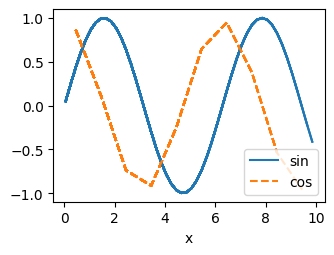

In [15]:
board = ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)